# Prelim Skills Exam
Submitted by: Emmanuel Q. Abo

Submitted to: Engr. Roman Richard

In [1]:
import numpy as np 
import pandas as pd 
import os
import glob

%matplotlib inline
import matplotlib.pyplot as plt

# Load Dataset

In [2]:
xray_df = pd.read_csv('archive/Data_Entry_2017.csv')
drop_cols = ['Follow-up #', 'Patient ID', 'Patient Age', 'Patient Gender', 'View Position',
            'OriginalImage[Width', 'Height]', 'OriginalImagePixelSpacing[x', 'y]']

# Drop the specified columns
xray_df.drop(columns=drop_cols, inplace=True)


In [3]:
image_paths = {os.path.basename(x): x for x in 
               glob.glob(os.path.join('archive', 'images*', '*', '*.png'))}

In [4]:
print('Total images scanned:', len(image_paths))
print('Total index', xray_df.shape[0])

Total images scanned: 112120
Total index 112120


In [5]:
print('Images found:', len(image_paths), ', Total Index', xray_df.shape[0])
xray_df['path'] = xray_df['Image Index'].map(image_paths.get)
xray_df.sample(5)

Images found: 112120 , Total Index 112120


,Image Index,Finding Labels,Unnamed: 11,path
91647,00022849_000.png,No Finding,NaN,archive\images_010\images\00022849_000.png
80522,00019770_003.png,Atelectasis,NaN,archive\images_009\images\00019770_003.png
78968,00019373_055.png,No Finding,NaN,archive\images_009\images\00019373_055.png
67198,00016588_001.png,No Finding,NaN,archive\images_008\images\00016588_001.png
45085,00011579_006.png,Effusion,NaN,archive\images_006\images\00011579_006.png


In [6]:

from itertools import chain
labels = np.unique(list(chain(*xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
labels = [x for x in labels if len(x)>0]
print('All Labels ({}): {}'.format(len(labels), labels))
for c_label in labels: # one-hot encoding
    if len(c_label)>1: # leave out empty labels
        xray_df[c_label] = xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
xray_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Unnamed: 11,path,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
76099,00018669_008.png,Atelectasis|Consolidation|Effusion|Infiltration,NaN,archive\images_009\images\00018669_008.png,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
29302,00007624_041.png,No Finding,NaN,archive\images_004\images\00007624_041.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
104557,00027973_000.png,Nodule,NaN,archive\images_011\images\00027973_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


# Prepare Train Data

In [7]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(xray_df, 
                                   test_size = 0.25, 
                                   random_state = 28,
                                   stratify = xray_df['Finding Labels'].map(lambda x: x[:4]))
print('train', train_df.shape[0], 'validation', test_df.shape[0])

train 84090 validation 28030


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
img_size = (224, 224)
core_idg = ImageDataGenerator(samplewise_center=True, 
                                  samplewise_std_normalization=True, 
                                  horizontal_flip = True, 
                                  vertical_flip = False, 
                                  height_shift_range= 0.05, 
                                  width_shift_range=0.1, 
                                  rotation_range=5, 
                                  shear_range = 0.1,
                                  fill_mode = 'reflect',
                                  zoom_range=0.15)

In [9]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    print('## Ignore next message from keras, values are replaced anyways')
    df_gen = img_data_gen.flow_from_directory(base_dir, 
                                     class_mode = 'sparse',
                                    **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = '' # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen

In [10]:
test_df['newLabel'] = test_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)
train_df['newLabel'] = train_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)

In [11]:
train_df.sample(5)

,Image Index,Finding Labels,Unnamed: 11,path,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,newLabel
18088,00004843_002.png,Consolidation|Infiltration,NaN,archive\images_003\images\00004843_002.png,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,"[Consolidation, Infiltration]"
15799,00004169_006.png,No Finding,NaN,archive\images_003\images\00004169_006.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,[No Finding]
38790,00010127_000.png,No Finding,NaN,archive\images_005\images\00010127_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,[No Finding]
76059,00018659_000.png,Infiltration,NaN,archive\images_009\images\00018659_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,[Infiltration]
3796,00001034_007.png,No Finding,NaN,archive\images_001\images\00001034_007.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,[No Finding]


In [12]:
train_gen = core_idg.flow_from_dataframe(dataframe=train_df,
directory=None,
x_col = 'path',
y_col = 'newLabel',
class_mode = 'categorical',
classes = labels,
target_size = img_size,
color_mode = 'rgb',
batch_size = 32)

valid_gen = core_idg.flow_from_dataframe(dataframe=test_df,
directory=None,
x_col = 'path',
y_col = 'newLabel',
class_mode = 'categorical',
classes = labels,
target_size = img_size,
color_mode = 'rgb',
batch_size = 256) 

test_X, test_Y = next(core_idg.flow_from_dataframe(dataframe=test_df,
directory=None,
x_col = 'path',
y_col = 'newLabel',
class_mode = 'categorical',
classes = labels,
target_size = img_size,
color_mode = 'rgb',
batch_size = 1024))

Found 84090 validated image filenames belonging to 15 classes.
Found 28030 validated image filenames belonging to 15 classes.
Found 28030 validated image filenames belonging to 15 classes.


In [13]:
X_train, y_train = next(train_gen)

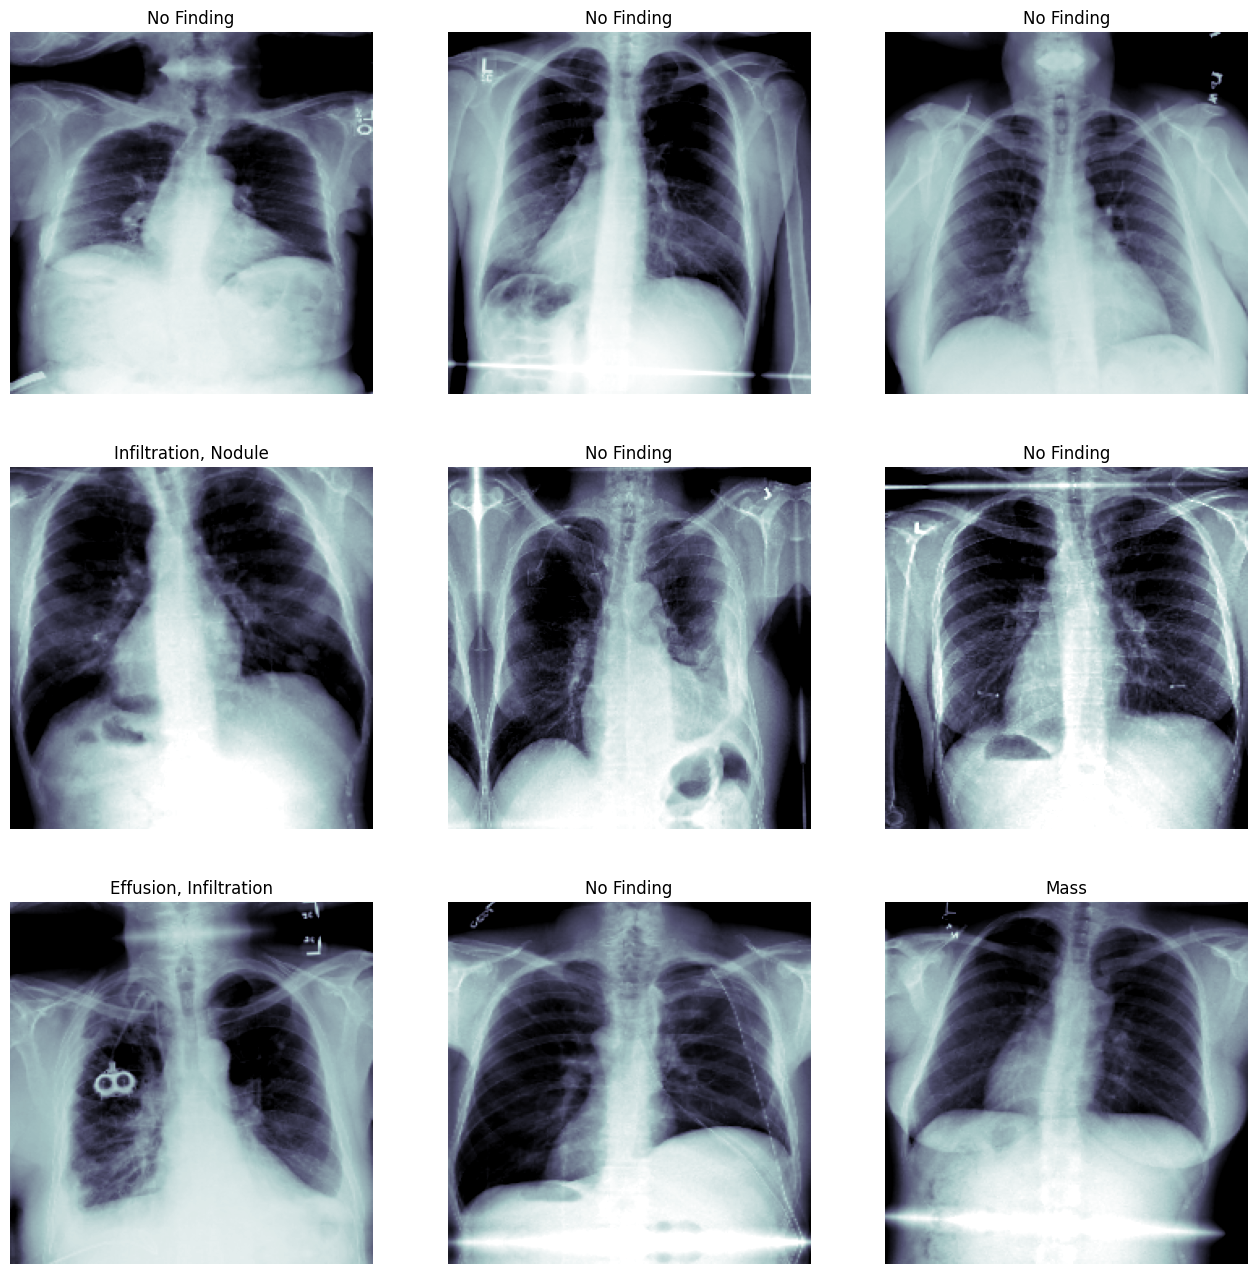

In [14]:
fig, m_axs = plt.subplots(3, 3, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(X_train, y_train, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -1.5, vmax = 1.5)
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(labels, c_y) 
                             if n_score>0.5]))
    c_ax.axis('off')

# MODEL FROM SCRATCH

Create the model

In [15]:
from keras.models import Sequential
from keras.layers import MaxPooling2D, Dense, Dropout, Flatten, Conv2D, Activation, BatchNormalization
from keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau

In [16]:
model_1 = Sequential()

# Convolutional layers
model_1.add(Conv2D(32, (2, 2), strides=(1, 1), input_shape=X_train.shape[1:], activation='relu'))
model_1.add(Conv2D(32, (2, 2), strides=(1, 1), activation='relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Dropout(0.25))

model_1.add(Conv2D(64, (2, 2), strides=(1, 1), activation='relu'))
model_1.add(Conv2D(64, (2, 2), strides=(1, 1), activation='relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Dropout(0.25))

model_1.add(Conv2D(128, (2, 2), strides=(1, 1), activation='relu'))
model_1.add(Conv2D(128, (2, 2), strides=(1, 1), activation='relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Dropout(0.25))

model_1.add(Conv2D(256, (2, 2), strides=(1, 1), activation='relu'))
model_1.add(Conv2D(256, (2, 2), strides=(1, 1), activation='relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Dropout(0.25))

# flatten layers
model_1.add(Flatten())
model_1.add(Dense(128, activation='relu'))
model_1.add(Dropout(0.25))

# output layer
model_1.add(Dense(len(labels), activation = 'sigmoid'))

model_1.summary()

C:\Users\MAWEL\anaconda3\envs\CPE313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 223, 223, 32)   │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 222, 222, 32)   │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 110, 110, 64)   │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 109, 109, 64)   │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 53, 53, 128)    │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 25, 25, 256)    │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 24, 24, 256)    │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,718,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,242,191 (20.00 MB)

 Trainable params: 5,242,191 (20.00 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
model_1.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['binary_accuracy'])
hist_1 = model_1.fit(
    train_gen,
    steps_per_epoch=50,
    epochs=5,
    verbose=1,
    validation_data=(test_X, test_Y))

Epoch 1/5


C:\Users\MAWEL\anaconda3\envs\CPE313\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/50 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - binary_accuracy: 0.8620 - loss: 0.3139 - val_binary_accuracy: 0.9242 - val_loss: 0.2414
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - binary_accuracy: 0.9219 - loss: 0.2274 - val_binary_accuracy: 0.9242 - val_loss: 0.2284
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - binary_accuracy: 0.9203 - loss: 0.2294 - val_binary_accuracy: 0.9278 - val_loss: 0.2102
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - binary_accuracy: 0.9232 - loss: 0.2234 - val_binary_accuracy: 0.9277 - val_loss: 0.2108
Epoch 5/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - binary_accuracy: 0.9264 - loss: 0.2210 - val_binary_accuracy: 0.9242 - val_loss: 0.2128


In [19]:
pred_Y = model_1.predict(test_X, batch_size = 32, verbose = True)


32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 271ms/step


C:\Users\MAWEL\anaconda3\envs\CPE313\Lib\site-packages\sklearn\metrics\_ranking.py:1146: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


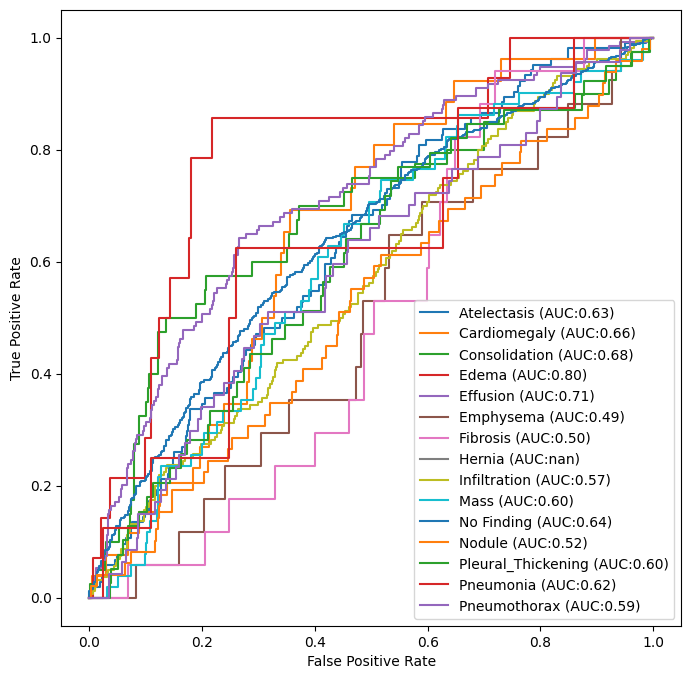

In [20]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (8, 8))
for (idx, c_label) in enumerate(labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('barely_trained_net.png')

<Figure size 1200x600 with 0 Axes>

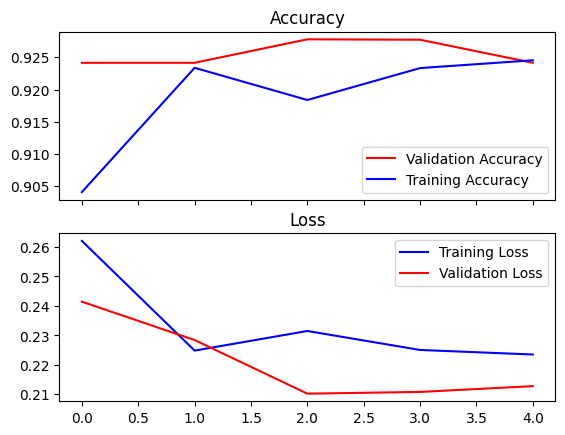

In [21]:
plt.figure(figsize=(12, 6))

fig, ax = plt.subplots(2, sharex=True)
ax[0].plot(hist_1.history["val_binary_accuracy"],'r', label="Validation Accuracy")
ax[0].plot(hist_1.history["binary_accuracy"],'b', label="Training Accuracy")
ax[0].set_title("Accuracy")

ax[1].plot(hist_1.history["loss"],'b', label="Training Loss")
ax[1].plot(hist_1.history["val_loss"],'r', label="Validation Loss")
ax[1].set_title("Loss")

ax[0].legend()
ax[1].legend()

# PRE-TRAINED MODEL

In [22]:
from keras.applications import VGG16
from keras.layers import GlobalAveragePooling2D, Input
from keras.models import Model
# Load pre-trained model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Modify
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(len(labels), activation='sigmoid')(x)

# Final Model
pre_trained_model = Model(inputs=base_model.input, outputs=predictions)

In [23]:
# Freeze pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

In [24]:
pre_trained_model.summary()

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,849,871 (56.65 MB)

 Trainable params: 135,183 (528.06 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [25]:
pre_trained_model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['binary_accuracy'])
pre_trained_hist_1 = pre_trained_model.fit(
    train_gen,
    steps_per_epoch=50,
    epochs=5,
    verbose=1,
    validation_data=(test_X, test_Y))

Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 287s 6s/step - binary_accuracy: 0.8337 - loss: 0.3729 - val_binary_accuracy: 0.9301 - val_loss: 0.2112
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 284s 6s/step - binary_accuracy: 0.9223 - loss: 0.2204 - val_binary_accuracy: 0.9244 - val_loss: 0.2089
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 299s 6s/step - binary_accuracy: 0.9203 - loss: 0.2228 - val_binary_accuracy: 0.9307 - val_loss: 0.2072
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 298s 6s/step - binary_accuracy: 0.9253 - loss: 0.2141 - val_binary_accuracy: 0.9320 - val_loss: 0.2027
Epoch 5/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 297s 6s/step - binary_accuracy: 0.9220 - loss: 0.2218 - val_binary_accuracy: 0.9313 - val_loss: 0.2034


In [26]:
pred_Y = pre_trained_model.predict(test_X, batch_size = 32, verbose = True)

32/32 ━━━━━━━━━━━━━━━━━━━━ 114s 4s/step


C:\Users\MAWEL\anaconda3\envs\CPE313\Lib\site-packages\sklearn\metrics\_ranking.py:1146: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


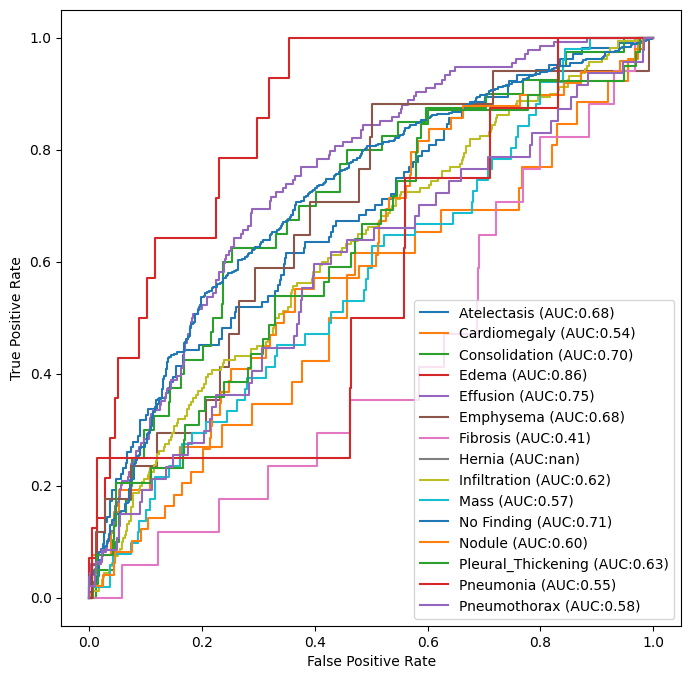

In [27]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (8, 8))
for (idx, c_label) in enumerate(labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('barely_trained_net.png')

<Figure size 1200x600 with 0 Axes>

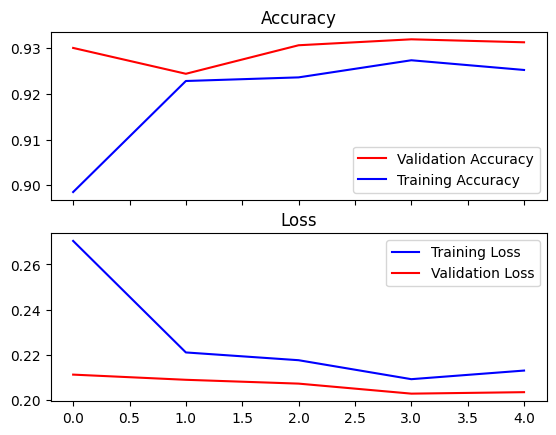

In [28]:
plt.figure(figsize=(12, 6))

fig, ax = plt.subplots(2, sharex=True)
ax[0].plot(pre_trained_hist_1.history["val_binary_accuracy"],'r', label="Validation Accuracy")
ax[0].plot(pre_trained_hist_1.history["binary_accuracy"],'b', label="Training Accuracy")
ax[0].set_title("Accuracy")

ax[1].plot(pre_trained_hist_1.history["loss"],'b', label="Training Loss")
ax[1].plot(pre_trained_hist_1.history["val_loss"],'r', label="Validation Loss")
ax[1].set_title("Loss")

ax[0].legend()
ax[1].legend()